In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GlobalMaxPool1D, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam, SGD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read Data
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
# Checking the head of data
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
# Checking the last rows of data
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [5]:
series = df['close'].values.reshape(-1,1)

In [6]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

In [7]:
# Build the data
T = 10
D = 1
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N = len(X)

In [8]:
# Build the model
i = Input(shape=(T,1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i,x)

In [9]:
#compile the model
model.compile(
    optimizer = Adam(lr=0.1),
    loss='mse'
)

# Train the model
r = model.fit(X[:-N//2],Y[:-N//2],validation_data=(X[-N//2:],Y[-N//2:]),epochs=80)

Epoch 1/80
20/20 [==============================] - 1s 26ms/step - loss: 0.2477 - val_loss: 0.6462
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0480 - val_loss: 0.3154
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.1061
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0638
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0578
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0549
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0557
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0575
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0507
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0626
Epoch 11/80
20/20 

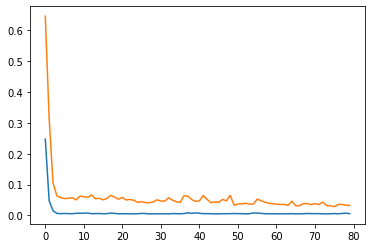

In [10]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')

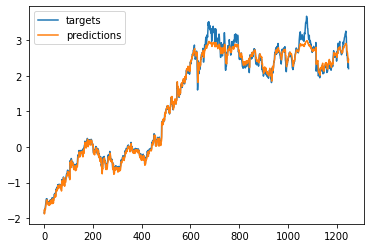

In [11]:
# One-step forecast
outputs = model.predict(X)
predictions = outputs[:,0]

plt.plot(Y,label='targets')
plt.plot(predictions,label='predictions')
plt.legend()

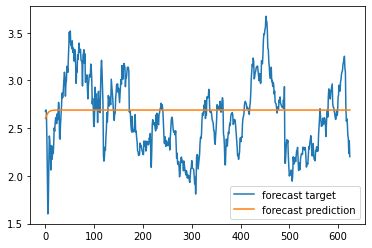

In [12]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [18]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

#Build the data set
T = 10
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N = len(X)

### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 0s 24ms/step - loss: 0.9920 - val_loss: 1.1453
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9888 - val_loss: 1.1582
Epoch 3/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9850 - val_loss: 1.1515
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9822 - val_loss: 1.1587
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9834 - val_loss: 1.1606
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9801 - val_loss: 1.1567
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9795 - val_loss: 1.1590
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9788 - val_loss: 1.1446
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9809 - val_loss: 1.1733
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9767 - val_loss: 1.1697
Epoch 11/80
20/20 

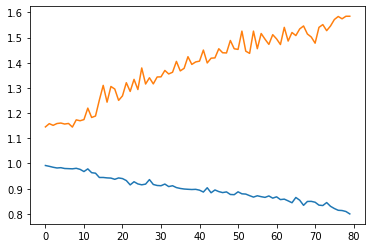

In [19]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')

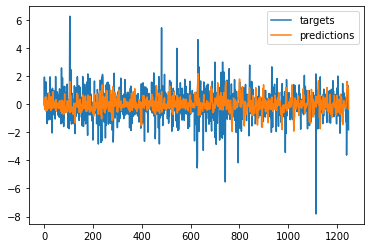

In [20]:
# One-step forecast
outputs = model.predict(X)
predictions = outputs[:,0]

plt.plot(Y,label='targets')
plt.plot(predictions,label='predictions')
plt.legend()

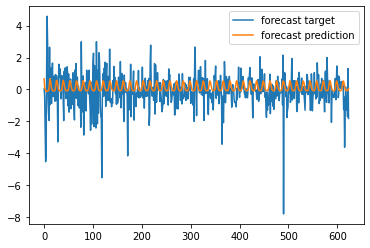

In [21]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [24]:
# Making the data from having all data columns into one array
input_data = df[['open','high','low','close','volume']].values
targets = df['Return'].values

In [26]:
# shape of data
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [27]:
Ntrain = len(input_data)*2//3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [28]:
# Setup Xtrain and Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [29]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [30]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [31]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 21ms/step - loss: 0.6970 - accuracy: 0.5173 - val_loss: 0.7032 - val_accuracy: 0.4854
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5316 - val_loss: 0.6927 - val_accuracy: 0.5122
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.4994 - val_loss: 0.6963 - val_accuracy: 0.4854
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6925 - accuracy: 0.5268 - val_loss: 0.6957 - val_accuracy: 0.4854
Epoch 5/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5280 - val_loss: 0.6974 - val_accuracy: 0.4854
Epoch 6/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5340 - val_loss: 0.6935 - val_accuracy: 0.5073
Epoch 7/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4982 - val_loss: 0.6926 - val_accuracy: 0.5220
Epoch 8/300


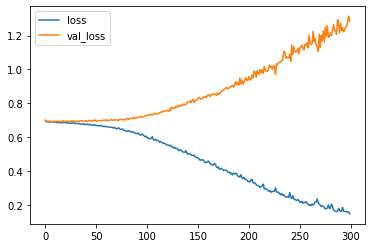

In [32]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

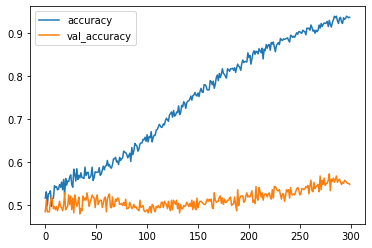

In [33]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()